This is a test Jupyter notebook for evaluating a chosen pre-trained CNN model on sequence data from the test patient set. Refer to test_patients_model.py for more details on the functions and their descriptions.

In [6]:
import sys
sys.path.insert(0,'/hpc/compgen/projects/fragclass/analysis/mvivekanandan/script/madhu_scripts')
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import h5py
from datetime import datetime
import time
import pickle

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import nn
from torch.nn.functional import one_hot

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

import sequenceCnnModel
import config
import utils

import importlib

importlib.reload(sequenceCnnModel)
importlib.reload(config)
importlib.reload(utils)

import seaborn as sns

In [7]:
arguments = {}
#File paths
# arguments["coordStoreDirectory"] = config.filePaths.get("coordStoreDirectory")
arguments["coordStoreDirectory"] = "/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/latestTwoTestCoordinateFiles"
arguments["patientTransplantStatusFile"] = config.filePaths.get("patientTransplantStatusFile")
arguments["modelStateDirectory"] = config.filePaths.get("modelStateDirectory")
arguments["testModelPlotsDir"] = config.filePaths.get("testModelPlotsDir")
arguments["refGenomePath"] = config.filePaths.get("refGenomePath")

#Model hyperparameters 
arguments["threshold"] = config.modelHyperParameters.get("classificationThreshold")
arguments["batchSize"] = config.modelHyperParameters.get("batchSize")
arguments["learningRate"] = config.modelHyperParameters.get("learningRate")
arguments["numEpochs"] = config.modelHyperParameters.get("numberEpochs")
arguments["numWorkers"] = config.modelHyperParameters.get("numberOfWorkers")

#Model general configs
arguments["modelName"] = config.modelGeneralConfigs.get("modelName")
arguments["storePlots"] = True
arguments["addLengthAsFeature"] = config.modelGeneralConfigs.get("addLengthAsFeature")
arguments["ddCfDnaPercentageThreshold"] = config.modelGeneralConfigs.get("ddCfDnaPercentageThreshold")

arguments["modelInputSequenceSize"] = config.modelHyperParameters.get("modelInputSequenceSize")
arguments["usePaddingForCnn"] = config.modelGeneralConfigs.get("usePaddingForCnn")

#Datasets
arguments["testCoordsDatasetName"] = config.datasetNames.get("testCoords")
arguments["testLabelsDatasetName"] = config.datasetNames.get("testLabels")

arguments["checkpointsFile"] = config.filePaths.get("checkpointsFile")

print(f"Arguments in validate_model script are {arguments}")
print(f"\n\n \033[1mDid you check whether interchangeLabels, sequenceDataset is set to the right configurations ??\033[0m")

Arguments in validate_model script are {'coordStoreDirectory': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/latestTwoTestCoordinateFiles', 'patientTransplantStatusFile': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/latest_test_patients_transplant_status.csv', 'modelStateDirectory': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/trainingValidationPlotsAndMetrics/final_report_cnn_models/27_10_11_20_31_lr_0.00001_filters_40_80', 'testModelPlotsDir': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/trainingValidationPlotsAndMetrics/final_report_patient_level_plots', 'refGenomePath': '/hpc/compgen/projects/fragclass/raw/hg19_genome/hg19_ch1-22_XYM.fa', 'threshold': 0.5, 'batchSize': 128, 'learningRate': 1e-05, 'numEpochs': 20, 'numWorkers': 12, 'modelName': 'combined_model_all_enformer_tracks', 'storePlots': True, 'addLengthAsFeature': True, 'ddCfDnaPercentageThreshold': 1, 'modelInputSequenceSize': 370, 'usePaddingForCnn': T

In [8]:
#Pick sequences from coordinate store directory. 
class PatientSequenceDataset(Dataset):
    def __init__(self, filename):
        self.filename = filename

    def __getitem__(self, index):     
        filepath = os.path.join(arguments["coordStoreDirectory"], self.filename)
        
        with h5py.File(filepath, 'r') as f:
            coord = f[arguments["testCoordsDatasetName"]][index]

            #Each sample should have only one label, it should be a single value instead of a numpy 1D array.The [0] is to make it a single value instead of a numpy array.
            # label = f['trainingLabels'][index][0]
            label = f[arguments["testLabelsDatasetName"]][:][index]

            # if(arguments["interchangeLabels"] == True):
            #     labels = self.interchangeLabels(labels)

            sequenceOutputLength = arguments["modelInputSequenceSize"]
            expected_sequence_length = 196607 if sequenceOutputLength == "enformer" else sequenceOutputLength
            encoded_input_sequence, _, og_sequence_length = utils.getOneHotEncodedSequenceFromCoordinates(coord, arguments["refGenomePath"],
                                                                                         sequenceOutputLength, arguments["usePaddingForCnn"])
            #For some cases, the coordinates look fine, but the sequence fetched from the fasta file has size 0. 
            #If we pass such samples to enformer for predictions, we get Einops error, due to dimension mismatch.
            assert encoded_input_sequence.shape == (expected_sequence_length, 4), f"One of the samples did not have the right dimensions({(expected_sequence_length, 4)}). The sample index is {index}, shape is {encoded_input_sequence.shape}, filename is {self.filename} and index within the file is {index}"

        return encoded_input_sequence, label, og_sequence_length

    def __len__(self):
        filepath = os.path.join(arguments["coordStoreDirectory"], self.filename)
        with h5py.File(filepath, 'r') as f:
            length = len(f[arguments["testLabelsDatasetName"]][:])
        return length
        

In [10]:
def getParametersDescription():
    if(arguments["modelInputType"] == "Sequence"):
        numPositives = 0
        numNegatives = 0
        labelsDatasetName = arguments["testLabelsDatasetName"]
        for filename in os.listdir(arguments["coordStoreDirectory"]):
            filePath = os.path.join(arguments["coordStoreDirectory"], filename)
            with h5py.File(filePath, 'r') as f:
                samples = f[labelsDatasetName][:]
                numPositives += (samples == 1).sum()
                numNegatives += (samples == 0).sum()

    elif(arguments["modelInputType"] == "Enformer"):
        with h5py.File(arguments["testEnformerStoreFile"], 'r') as f:
            samples = f[labelsDatasetName][:]
            numPositives = (samples == 1).sum()
            numNegatives = (samples == 0).sum()

    totalSamples = numPositives + numNegatives
    description = (f"Number of samples = {totalSamples} ({numPositives} positives and {numNegatives} negatives)")
    return description

def get_softmax(preds_array):
    preds_exp = np.exp(preds_array)
    sum_array = np.sum(preds_exp, axis = 1)
    softmax_preds = preds_exp/sum_array[:, None]
    return softmax_preds

def getClassPredictionsAndProbsFromOutput(plotsData):
    threshold = arguments["threshold"]
    predicted_labels = []
    predictions = plotsData["predictions"]

    #Apply softmax function to convert the prediction into probabilities between 0 and 1. This is used for plotting
    #the frequency of the outcomes to know how sure the model was for different data points. 
    #Model prediction is a 2D array of size (batchSize * 2). The 2 values are the probabilities for the positive and negative for each sample in the batch.
    # Whichever of the 2 labels has the highest probabilities is taken as the final predicted label of the model. 
    #If the probabilities added upto 1, this would count as taking 0.5 as the threshold for considering a class as the prediction. 
    #Iterate through all the positive probabilities predictions in the batch and extend the predictions list with all the predictions for the batch. 
    softmax_preds = np.around(get_softmax(predictions), 4)
    #TODO figure out which probability is for the positives. 
    softmax_positives = softmax_preds.transpose()[1].flatten()
    for prob in softmax_positives: 
        if prob > threshold: 
            predicted_labels.append(1)
        else:
            predicted_labels.append(0)

    return softmax_positives, predicted_labels

def getPatientLevelPercentDonorTranplantStatusPredictions(patient_donor_count):
    col_names = ["patient_sample_id", "num_samples", "donor_percentage", "Metadata Donor Percent", "DaysPostTransplant", "Clinical_signs_of_rejection", "patient_id"]
    patient_labels_df = pd.read_csv(arguments["patientTransplantStatusFile"], sep = "\t", names= col_names, skiprows=1)
    patient_level_donor_percents = {}
    true_transplant_statuses = {}
    predicted_transplant_statuses = {}

    for patient_id, num_donors in patient_donor_count.items():
        condition = (patient_labels_df['patient_sample_id'] == patient_id)
        num_samples = patient_labels_df.loc[condition, 'num_samples'].values[0]

        true_transplant_status = patient_labels_df.loc[condition, 'Clinical_signs_of_rejection'].values[0]
        true_transplant_status = 1 if true_transplant_status == "Yes" else 0
        true_transplant_statuses[patient_id] = true_transplant_status

        percent_donors = (num_donors/num_samples)*100
        patient_level_donor_percents[patient_id] = percent_donors

        if(percent_donors > arguments["ddCfDnaPercentageThreshold"]):
            predicted_transplant_statuses[patient_id] = 1
        else:
            predicted_transplant_statuses[patient_id] = 0
    
    return patient_level_donor_percents, predicted_transplant_statuses, true_transplant_statuses

def getConfusionMatrixLabels(cf_matrix):
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    cf_matrix_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    cf_matrix_labels = np.asarray(cf_matrix_labels).reshape(2,2)
    return cf_matrix_labels

def storeConfusionMatrixHeatMap(plotsData, predicted_labels, plotsDirectoryPath):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 8))
    heatmap_description = getParametersDescription()
    fig.text(.5, -0.1, heatmap_description, ha = 'center', fontsize=12)
    
    #Get fragment level confusion matrix
    fragment_true_labels = plotsData["labels"]
    fragment_cf_matrix = confusion_matrix(fragment_true_labels, predicted_labels)
    fragment_cf_matrix_labels = getConfusionMatrixLabels(fragment_cf_matrix)

    #Get patient level confusion matrix
    predicted_transplant_status = plotsData["predicted_transplant_status"]
    true_transplant_status = plotsData["true_transplant_status"]

    patient_cf_matrix = confusion_matrix(list(true_transplant_status.values()), list(predicted_transplant_status.values()))
    patient_cf_matrix_labels = getConfusionMatrixLabels(patient_cf_matrix)

    s1 = sns.heatmap(fragment_cf_matrix, annot=fragment_cf_matrix_labels, fmt = '', cmap="Blues", ax=ax1, annot_kws={"fontsize":12})
    s2 = sns.heatmap(patient_cf_matrix, annot=patient_cf_matrix_labels, fmt = '', cmap="Blues", ax=ax2, annot_kws={"fontsize":12})
    s1.set_xlabel("Predicted Label", fontsize=12)
    s1.set_ylabel("True Label", fontsize=12)
    s2.set_xlabel("Predicted Label", fontsize=12)
    s2.set_ylabel("True Label", fontsize=12)
    fig.subplots_adjust(hspace=0.75, wspace=0.75)

    ax1.title.set_text(f'Fragment level')
    ax2.title.set_text(f'Patient level')

    if(arguments["storePlots"]):
        plotPath = os.path.join(plotsDirectoryPath, "confusionMatrix")
        plt.savefig(plotPath, bbox_inches='tight')

    plt.show()
    plt.clf()

"""
Given a plotsData dict which has the predicted percent donors, the function makes a correlation plot between 
true predicted donors and predicted percentage donors 
The true donor percentage can be calculated by the number of samples in donor and recipient files for each patient. For that pass true_donor_percent = "calculated"
Or the true donor percent can be directly picked up from the metadata supplied by the authors. For that, pass true_donor_percent = "metadata"
Strangely there is a lot of discrepancy between these 2 values. Wonder how the authors in the study populated the true % donors in the metadata CSV
To get the accuracy of the model, it makes more sense to use the calculated % donors since that is what the model sees. 
"""
def storePredictedDonorsCorrelationPlot(plotsData, plotsDirectoryPath, true_donor_percent = "calculated"):
    col_names = ["patient_sample_id", "num_samples", "donor_percentage", "Metadata Donor Percent", "DaysPostTransplant", "Clinical_signs_of_rejection", "patient_id"]
    patient_labels_df = pd.read_csv(arguments["patientTransplantStatusFile"], sep = "\t", names= col_names, skiprows=1)
    donor_percentage_predictions = list(plotsData["predicted_donor_percentage"].values())
    if (true_donor_percent == "calculated"):
        true_donor_percentage = patient_labels_df[patient_labels_df['patient_sample_id'].isin( plotsData["predicted_donor_percentage"].keys())]["donor_percentage"]
    else:
        true_donor_percentage = patient_labels_df[patient_labels_df['patient_sample_id'].isin( plotsData["predicted_donor_percentage"].keys())]["Metadata Donor Percent"]
    
    plt.scatter(true_donor_percentage, donor_percentage_predictions)
    plt.title(f'Correlation between predicted vs actual % donors')
    plt.xlabel('True % donors')
    plt.ylabel('Predicted %')

    #Set x lims
    plt.xlim(0, 20)

    if(arguments["storePlots"]):
        plotPath = os.path.join(plotsDirectoryPath, "percentageDonorsCorrelationPlot")
        plt.savefig(plotPath, bbox_inches='tight')
    plt.show()
    plt.clf()

#Plot a seaborn joint plot- so create a new dataframe - with the columns - daysPostTransplant, predictedDonorpercentage, truePredictedDonorPercentage and clinical signs of rejection and patient
def storePercentDdCfDnaTransplantDaysPlot(plotsData):
    col_names = ["patient_sample_id", "num_samples", "donor_percentage", "Metadata Donor Percent", "DaysPostTransplant", "Clinical_signs_of_rejection", "patient_id"]
    patient_labels_df = pd.read_csv(arguments["patientTransplantStatusFile"], sep = "\t", names= col_names, skiprows=1)

    #Cope only some rows from the transplant status file to a new df - the rows for which the model predictions were obtained
    predicted_percent_donors = plotsData["predicted_donor_percentage"]
    condition = patient_labels_df['patient_sample_id'].isin(predicted_percent_donors.keys())
    to_plot_df = patient_labels_df[condition].copy()
    to_plot_df.reset_index(drop=True, inplace=True)

    #To the copied df, add the percentage donor values from the model predictions
    predicted_percent_donors_list = []
    for index, row in to_plot_df.iterrows():
        patient_sample_id = row["patient_sample_id"]
        print(f"Row patient_sample_id: {patient_sample_id}")
        predicted_percent_donors_list.append(predicted_percent_donors[row["patient_sample_id"]])
    to_plot_df["predicted_percent_donors"] = predicted_percent_donors_list
    print(f"Got the final df for plotting %dd cf-DNA vs transplant days. Printing it")
    print(to_plot_df.head(10))

    # Create the scatter plots with different color palettes
    scatter = sns.scatterplot(data=to_plot_df, x="DaysPostTransplant", y="predicted_percent_donors", hue="Clinical_signs_of_rejection")
    scatter.legend_.set_title("Clinical signs of rejection")

    scatter.legend_.set_title("Clinical Signs of Rejection")
    
    sns.lineplot(data=to_plot_df, x="DaysPostTransplant", y='predicted_percent_donors', color="gray", alpha=0.2)

    plt.legend()
    plt.show()

def storeAucAndRocCurve(probabilities, plotsData, plotsDirectoryPath):
    #Get AUC and TPR, FPR for training
    labels = plotsData["labels"]
    auc_score = roc_auc_score(labels, probabilities)
    fpr, tpr, _ = roc_curve(labels, probabilities, pos_label=1)

    #Get AUC, TPR, FPR for a random predictor
    random_pred_val = [0 for i in range(len(labels))]
    r_fpr, r_tpr, _ = roc_curve(labels, random_pred_val, pos_label=1)

    plt.plot(fpr, tpr, linestyle='--',color='red', label='Test model ROC curve')
    plt.plot(r_fpr, r_tpr, linestyle='--', color='black')
    plt.title(f'ROC curve plot: AUC : {auc_score}')
    plt.xlabel('False Positive Rate/FPR')
    plt.ylabel('True Positive Rate/TPR')
    plt.legend(loc='best')
    if(arguments["storePlots"]):
        plotPath = os.path.join(plotsDirectoryPath, "ROC")
        plt.savefig(plotPath, bbox_inches='tight')

    plt.show()
    plt.clf()

def storeDataAndMakePlots(plotsDirectoryPath, plotsData, class_predictions, output_probabilities, modelInputType):
    plt.style.use('seaborn')
    arguments["modelInputType"] = modelInputType

    output_probabilities, class_predictions = getClassPredictionsAndProbsFromOutput(plotsData)
    
    storeAucAndRocCurve(output_probabilities, plotsData, plotsDirectoryPath)

    #Plot confusion matrix heat map for training and validation (only for last epoch)
    storeConfusionMatrixHeatMap(plotsData, class_predictions, plotsDirectoryPath)

    #Plot the correlation between predicted percentage donors and actual percentage donors for each sample 
    storePredictedDonorsCorrelationPlot(plotsData, plotsDirectoryPath)

    # Plot the predicted percentage dd-cfDNA over days of transplant for a patient. 
    
    storePercentDdCfDnaTransplantDaysPlot(plotsData)

In [12]:
def runModelAndGetPredictionsForPatient(patient_file_name, cnnModel, criterion):
    plotsData = {"labels": {}, "predictions": {}, "loss": {}}
    
    dataset = PatientSequenceDataset(patient_file_name)
    dataloader = DataLoader(dataset, batch_size=arguments["batchSize"], 
                                    num_workers=arguments["numWorkers"])

    num_batches = len(dataloader)
    store_plotting_data_interval = 3 if num_batches > 3000 else 1
    running_loss = 0.0

    modelPredictionsToRet = np.zeros(shape = (1, 2))
    modelInputLabelsToRet = []

    for i, data in enumerate(dataloader):
        sequence, class_labels, og_sequence_length = data
        if torch.cuda.is_available():
            sequence = sequence.to("cuda")
            class_labels = class_labels.to("cuda")
        
        #Reshaping to have the structure (batches, channels, sequence_length, 4)
        batches, sequence_length, one_hot_base_length = sequence.shape
        sequence = sequence.reshape(batches, 1, sequence_length, one_hot_base_length)
        class_labels = class_labels.to(torch.int64).flatten()
        og_sequence_length = og_sequence_length.reshape(len(og_sequence_length), 1).to("cuda")

        probabilityLabels = one_hot(class_labels, num_classes=2).to(torch.float32)
        modelPrediction = cnnModel(sequence, og_sequence_length, arguments["addLengthAsFeature"])

        loss = criterion(modelPrediction, probabilityLabels)
        running_loss += loss.item()

        if(i % store_plotting_data_interval == 0):
            # modelInputDataToRet =  np.row_stack([modelInputDataToRet, sequence.detach().cpu().numpy()])
            modelInputLabelsToRet.extend(class_labels.cpu())
            modelPredictionsToRet = np.row_stack([modelPredictionsToRet, modelPrediction.detach().cpu().numpy()])
        if(i % 100 == 0):
            print(f"Completed predictions for batch {i}")
    
    print(f"Finished all batches, storing the data now !!!")
    avg_loss_per_batch = running_loss/len(dataloader)
    plotsData["loss"] = avg_loss_per_batch
    plotsData["labels"] = modelInputLabelsToRet
    plotsData["predictions"] = modelPredictionsToRet[1:, :]
    return plotsData

def getPatientLevelPredictedDonors(filename, predictions, patient_percent_donors):
    patient_id = filename.replace(".recipient.hdf5", "").replace(".donor.hdf5", "")
    predicted_donors = predictions.count(1)
    if(patient_id in patient_percent_donors):
        patient_percent_donors[patient_id] = patient_percent_donors[patient_id] + predicted_donors
    else:
        patient_percent_donors[patient_id] = predicted_donors
    return patient_percent_donors


def plotPrecisionRecallCurve(positive_probs, true_labels, plotsDirectoryPath):
    precision, recall, thresholds = precision_recall_curve(true_labels, positive_probs)

    # Plot the precision-recall curve with style enhancements
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Precision-Recall Curve', color='orange', linewidth=2)  # Brighter color, thicker line

    # Set labels and title
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curve', fontsize=14)

    if(arguments["storePlots"]):
        plotPath = os.path.join(plotsDirectoryPath, "precisionRecallPlot")
        plt.savefig(plotPath, bbox_inches = "tight")
    
    plt.show()
    plt.clf()
    
def combinePredictionsFromAllPatients(plotsDirectoryPath):
    #Load state dict into the model 
    cnnModel = sequenceCnnModel.SequenceCnnModel(0).to('cuda')
    arg1 =arguments["modelStateDirectory"]
    arg2 = arguments["checkpointsFile"]
    print(f"About to get checkpoints path, the arguments are {arg1} and {arg2}")
    checkpoint_path = os.path.join(arguments["modelStateDirectory"], arguments["checkpointsFile"])
    checkpoint_dict = torch.load(checkpoint_path)
    cnnModel.load_state_dict(checkpoint_dict["model_state_dict"])
    cnnModel.eval()

    criterion = nn.CrossEntropyLoss()

    allPlotsData = {"labels": [], "predictions": [], "covered_files": []}

    all_class_predictions = []
    all_output_probabilities = []
    patient_predicted_donors = {}

    num_patients = 0
    total_loss = 0

    data_pickle_file_path = os.path.join(arguments["testModelPlotsDir"], "testPatientsData.pkl")
    percent_donors_file = os.path.join(arguments["testModelPlotsDir"], "patientPercentDonors.pkl")

    for filename in os.listdir(arguments["coordStoreDirectory"]):
        print(f"Processing filename  : {filename}")
        num_patients += 1
        plotsData = runModelAndGetPredictionsForPatient(filename, cnnModel, criterion)
        loss = plotsData["loss"]
        print(f"for filename, loss is {loss}")
        total_loss += plotsData["loss"]
        if "labels" in allPlotsData:
            allPlotsData["labels"].extend(plotsData["labels"])
        else:
            allPlotsData["labels"] = plotsData["labels"]
        
        if "predictions" in allPlotsData:
            allPlotsData["predictions"].extend(plotsData["predictions"])
        else:
            allPlotsData["predictions"] = plotsData["predictions"]

        allPlotsData["covered_files"].append(filename)

        # This gets the output probability of only the positives. And the class that was predicted based on applying classification threshold to the output probability
        output_probabilities, class_predictions = getClassPredictionsAndProbsFromOutput(plotsData)
        all_class_predictions.extend(class_predictions)
        all_output_probabilities.extend(output_probabilities)

        #Store data at the end of every file
        #We need all_plots data to get appended to everytime. So no other option. 
        with open(data_pickle_file_path, "wb") as f:
            pickle.dump(allPlotsData, f)

        #Patient level predicted donors is a map of patient id vs number of predicted donors for the patient 
        patient_predicted_donors = getPatientLevelPredictedDonors(filename, class_predictions, patient_predicted_donors)
        with open(percent_donors_file, "wb") as f:
            pickle.dump(patient_predicted_donors, f)

    print(f"After processing all patients, the patient level donor predictions is {patient_predicted_donors}")

    #Code to retrieve plotsData and percent_donors from pickle files 
    with open(data_pickle_file_path, "rb") as f:
        allPlotsData = pickle.load(f)
    
    with open(percent_donors_file, 'rb') as f:
        patient_predicted_donors = pickle.load(f)
        
    patient_donor_percent, predicted_transplant_status, true_transplant_status = getPatientLevelPercentDonorTranplantStatusPredictions(patient_predicted_donors)
    allPlotsData["loss"] = total_loss/num_patients
    allPlotsData["predicted_donor_count"] = patient_predicted_donors
    allPlotsData["predicted_donor_percentage"] = patient_donor_percent
    allPlotsData["predicted_transplant_status"] = predicted_transplant_status
    allPlotsData["true_transplant_status"] = true_transplant_status
    print(f"After getting predictions, the plotsData values are {patient_predicted_donors}, {patient_donor_percent}, {predicted_transplant_status}, {true_transplant_status}")
    
    predictions = allPlotsData["predictions"]
    labels = allPlotsData["labels"]
    softmax_preds = np.around(get_softmax(predictions), 4)   #all the predictions (in terms of probabilities) for a batch 
    softmax_positives = softmax_preds.transpose()[1].flatten() 
    plotPrecisionRecallCurve(softmax_positives, labels, plotsDirectoryPath)
    # storeDataAndMakePlots(plotsDirectoryPath, allPlotsData, all_output_probabilities, all_class_predictions, modelInputType="Sequence")

Start time is 1702507825.0454035
About to get checkpoints path, the arguments are /hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/trainingValidationPlotsAndMetrics/final_report_cnn_models/27_10_11_20_31_lr_0.00001_filters_40_80 and modelCheckPoints
Processing filename  : L33-M3.recipient.hdf5
Completed predictions for batch 0
Completed predictions for batch 100
Completed predictions for batch 200
Completed predictions for batch 300
Completed predictions for batch 400
Completed predictions for batch 500
Completed predictions for batch 600
Completed predictions for batch 700
Completed predictions for batch 800
Completed predictions for batch 900
Completed predictions for batch 1000
Completed predictions for batch 1100
Completed predictions for batch 1200
Finished all batches, storing the data now !!!
for filename, loss is 0.6968925039523588
Processing filename  : L33-M3.donor.hdf5
Completed predictions for batch 0
Finished all batches, storing the data now !!!
for filename,

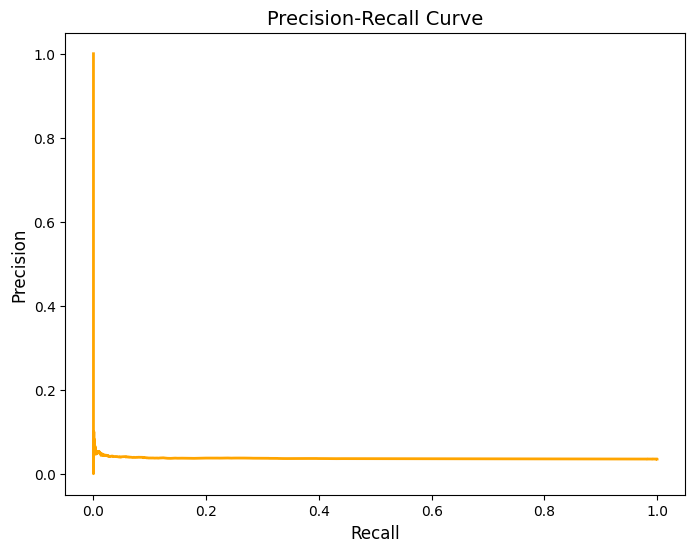

End time is 1702508071.1090114


<Figure size 640x480 with 0 Axes>

In [13]:
if __name__ == '__main__':
    print(f"Start time is {time.time()}")
    
    now = datetime.now()
    filename_extension = now.strftime("%d_%m_%H_%M_%S")
    # modelname = arguments["modelName"]
    modelname = "cnn_model_precision_recall_curve"
    plotsDirectoryName = filename_extension + "_" + str(modelname)
    plotsDirectoryPath = os.path.join(arguments["testModelPlotsDir"], plotsDirectoryName)
    os.mkdir(plotsDirectoryPath)

    combinePredictionsFromAllPatients(plotsDirectoryPath)   
    print(f"End time is {time.time()}")   

**Remove patients where one of donors or recipients were not processed**

In [3]:
#All donors and recipients that were processed in the first run
all_list = ["L36-M3.recipient.hdf5","L33-M8.recipient.hdf5", "L80-W2.donor.hdf5","L79-W2.donor.hdf5","L68-M12.donor.hdf5","L77-D1-1.donor.hdf5","L81-M2.donor.hdf5","L58-M3.recipient.hdf5","L59-M12.recipient.hdf5","L9b-W2.donor.hdf5","L81-M2.recipient.hdf5","L82-M1-5.donor.hdf5","L74-W1.donor.hdf5","L81-D1.1.donor.hdf5","L16-M23.recipient.hdf5","L1-M13.recipient.hdf5","L77-D1-3.donor.hdf5","L33-M3.recipient.hdf5","L85-M9.donor.hdf5","L34-M6.recipient.hdf5","L33-M3.donor.hdf5","L81-D2-1.recipient.hdf5","L81-W2.recipient.hdf5","L5-M13_5.donor.hdf5","L33-M8.donor.hdf5","L34-M6.donor.hdf5","L77-D1-3.recipient.hdf5","L16-M23.donor.hdf5","L49-M14-5.recipient.hdf5","L59-M6.donor.hdf5","L81-D1.1.recipient.hdf5","L49-M14.recipient.hdf5","L35-W2.donor.hdf5","L59-M2-5.recipient.hdf5","L30-M2.recipient.hdf5","L33-M2-5.recipient.hdf5","L74-D2-1.recipient.hdf5","L33-M2-5.donor.hdf5","L2-M25.donor.hdf5","L68-M12.recipient.hdf5","L69-M6.donor.hdf5","L49-M9.donor.hdf5","L35-W2.recipient.hdf5","L4-M25.recipient.hdf5","L74-D2-2.donor.hdf5","L81-M3.donor.hdf5","L79-M6-1.donor.hdf5","L9b-W2.recipient.hdf5","L69-M6.recipient.hdf5","L80-W2.recipient.hdf5","L82-M1-5.recipient.hdf5","L69-M2.donor.hdf5","L30-M2.donor.hdf5","L69-M2.recipient.hdf5","L5-M13_5.recipient.hdf5","L81-M3.recipient.hdf5","L74-D2-1.donor.hdf5","L11-M35.recipient.hdf5","L2-M25.recipient.hdf5","L36-W2.donor.hdf5","L31-M8.recipient.hdf5","L59-M6.recipient.hdf5","L25-M18.recipient.hdf5"]

#All donors and recipients that were processed in the second run
extra_list = ["L36-M3.recipient.hdf5", "L79-W2.donor.hdf5", "L77-D1-1.donor.hdf5", "L58-M3.recipient.hdf5", "L59-M12.recipient.hdf5", "L74-W1.donor.hdf5", "L1-M13.recipient.hdf5", "L85-M9.donor.hdf5", "L81-D2-1.recipient.hdf5", "L81-W2.recipient.hdf5", "L49-M14-5.recipient.hdf5", "L49-M14.recipient.hdf5", "L59-M2-5.recipient.hdf5", "L49-M9.donor.hdf5", "L4-M25.recipient.hdf5", "L74-D2-2.donor.hdf5", "L79-M6-1.donor.hdf5", "L11-M35.recipient.hdf5", "L36-W2.donor.hdf5", "L31-M8.recipient.hdf5", "L25-M18.recipient.hdf5", "L36-M14.donor.hdf5", "L79-M6-1.recipient.hdf5", "L34-M2-5.donor.hdf5", "L49-M9.recipient.hdf5", "L21-M23.donor.hdf5", "L79-W2.recipient.hdf5", "L49-M16.donor.hdf5", "L21-M23.recipient.hdf5", "L50-M14.donor.hdf5", "L4-M25.donor.hdf5", "L36-M14.recipient.hdf5", "L11-M35.donor.hdf5", "L30-M1-25.recipient.hdf5", "L57-M1.donor.hdf5", "L50-M1-5.recipient.hdf5", "L85-M9.recipient.hdf5", "L28-M3.donor.hdf5", "L1-M13.donor.hdf5", "L28-M3.recipient.hdf5", "L49-M14-5.donor.hdf5", "L34-M2-5.recipient.hdf5", "L74-D2-2.recipient.hdf5", "L74-W1.recipient.hdf5", "L36-W2.recipient.hdf5", "L59-M12.donor.hdf5", "L36-M3.donor.hdf5", "L58-M3.donor.hdf5", "L49-M16.recipient.hdf5", "L31-M8.donor.hdf5", "L50-M14.recipient.hdf5", "L81-D2-1.donor.hdf5", "L49-M14.donor.hdf5", "L59-M2-5.donor.hdf5", "L50-M1-5.donor.hdf5", "L81-W2.donor.hdf5", "L77-D1-1.recipient.hdf5", "L30-M1-25.donor.hdf5", "L57-M1.recipient.hdf5"]
all_list.extend(extra_list)

covered_donor_recip_list = []
covered_patient_list = []
for filename in all_list:
    if "recipient" in filename: continue
    recip_file = filename.replace("donor", "recipient")
    if(recip_file in all_list):
        covered_donor_recip_list.append(filename)
        covered_donor_recip_list.append(recip_file)
        covered_patient_list.append(recip_file.replace(".recipient.hdf5", ""))

covered_donor_recip_list = list(set(covered_donor_recip_list))
covered_patient_list = list(set(covered_patient_list))

print(len(covered_donor_recip_list))
print(covered_donor_recip_list)
print(len(covered_patient_list))
print(covered_patient_list)

test_dir = "/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/latestTestCoordinateFiles"
print(len(os.listdir(test_dir)))

100
['L35-W2.recipient.hdf5', 'L77-D1-3.donor.hdf5', 'L77-D1-3.recipient.hdf5', 'L49-M16.donor.hdf5', 'L30-M2.recipient.hdf5', 'L50-M1-5.recipient.hdf5', 'L79-M6-1.recipient.hdf5', 'L49-M14.donor.hdf5', 'L4-M25.recipient.hdf5', 'L2-M25.donor.hdf5', 'L81-M3.recipient.hdf5', 'L33-M8.recipient.hdf5', 'L77-D1-1.recipient.hdf5', 'L81-D1.1.recipient.hdf5', 'L69-M2.recipient.hdf5', 'L49-M16.recipient.hdf5', 'L81-D2-1.recipient.hdf5', 'L34-M6.donor.hdf5', 'L68-M12.recipient.hdf5', 'L31-M8.donor.hdf5', 'L33-M3.donor.hdf5', 'L57-M1.donor.hdf5', 'L81-M2.recipient.hdf5', 'L58-M3.recipient.hdf5', 'L59-M6.donor.hdf5', 'L81-W2.donor.hdf5', 'L79-W2.recipient.hdf5', 'L1-M13.donor.hdf5', 'L9b-W2.recipient.hdf5', 'L74-D2-1.donor.hdf5', 'L68-M12.donor.hdf5', 'L34-M2-5.recipient.hdf5', 'L2-M25.recipient.hdf5', 'L21-M23.donor.hdf5', 'L30-M1-25.recipient.hdf5', 'L33-M8.donor.hdf5', 'L30-M1-25.donor.hdf5', 'L34-M2-5.donor.hdf5', 'L49-M9.recipient.hdf5', 'L74-D2-2.recipient.hdf5', 'L30-M2.donor.hdf5', 'L36-W2.

**If percent donor data is already stored, combine the data from multiple runs, filter out some patients and get the data ready for plotting**

In [8]:
plotsDir = "/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/trainingValidationPlotsAndMetrics/final_report_patient_level_plots/15_11_23_21_08_all_test_patients"
percent_donors_file = os.path.join(plotsDir, "patientPercentDonors.pkl")

with open(percent_donors_file, 'rb') as f:
    patient_predicted_donors = pickle.load(f)

print(f"Number of patients covered in 1st iteration: {len(list(patient_predicted_donors.keys()))}")

plotsDir = "/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/trainingValidationPlotsAndMetrics/final_report_patient_level_plots/16_11_17_19_17_all_test_patients_part_2"
percent_donors_file = os.path.join(plotsDir, "patientPercentDonors.pkl")

with open(percent_donors_file, 'rb') as f:
    patient_predicted_donors_2 = pickle.load(f)

print(f"Number of patients covered in 2nd iteration: {len(list(patient_predicted_donors_2.keys()))}")

patient_predicted_donors.update(patient_predicted_donors_2)
print(f"Number of patients covered in both iterations : {len(list(patient_predicted_donors.keys()))}")

'''
Mostly plots data is huge because large number of fragments. So the process for getting predictions is usually stopped midway
For some patients, the donor files are completed and predictions are accounted for, but recipients are not done still
Make sure that such patients are removed while making the correlation plots, because numbers are incorrect.
to_include_patients is the list of patients for both donors and recipients were not processed. 
This list was manually generated by looking through the logs and checking which files were successfully processed.
'''
filtered_percent_donors = {key: value for key, value in patient_predicted_donors.items() if key in covered_patient_list}
print(f"Actual patients covered in both iterations: {len(list(filtered_percent_donors.keys()))}")

allPlotsData = {}
patient_donor_percent, predicted_transplant_status, true_transplant_status = getPatientLevelPercentDonorTranplantStatusPredictions(filtered_percent_donors)
# allPlotsData["loss"] = total_loss/num_patients
allPlotsData["predicted_donor_count"] = patient_predicted_donors
allPlotsData["predicted_donor_percentage"] = patient_donor_percent
allPlotsData["predicted_transplant_status"] = predicted_transplant_status
allPlotsData["true_transplant_status"] = true_transplant_status
print(f"After getting predictions, the plotsData values are {patient_predicted_donors}, {patient_donor_percent}, {predicted_transplant_status}, {true_transplant_status}")


Number of patients covered in 1st iteration: 42
Number of patients covered in 2nd iteration: 30
Number of patients covered in both iterations : 51
Actual patients covered in both iterations: 50
After getting predictions, the plotsData values are {'L36-M3': 183516, 'L33-M8': 25811, 'L80-W2': 50966, 'L79-W2': 101744, 'L68-M12': 96082, 'L77-D1-1': 51510, 'L81-M2': 66220, 'L58-M3': 124824, 'L59-M12': 75619, 'L9b-W2': 13897, 'L82-M1-5': 162223, 'L74-W1': 67497, 'L81-D1.1': 85770, 'L16-M23': 47188, 'L1-M13': 21647, 'L77-D1-3': 107787, 'L33-M3': 83908, 'L85-M9': 150389, 'L34-M6': 118565, 'L81-D2-1': 92702, 'L81-W2': 58931, 'L5-M13_5': 58758, 'L49-M14-5': 95313, 'L59-M6': 108342, 'L49-M14': 71585, 'L35-W2': 165763, 'L59-M2-5': 158177, 'L30-M2': 92652, 'L33-M2-5': 20207, 'L74-D2-1': 75398, 'L2-M25': 40887, 'L69-M6': 98967, 'L49-M9': 45826, 'L4-M25': 16205, 'L74-D2-2': 67286, 'L81-M3': 62194, 'L79-M6-1': 97957, 'L69-M2': 127230, 'L11-M35': 86513, 'L36-W2': 164001, 'L31-M8': 55566, 'L25-M18': 116

**Make correlation plot of true % donors vs predicted % donors**

/hpc/compgen/users/mvivekanandan/miniconda/envs/fragenv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


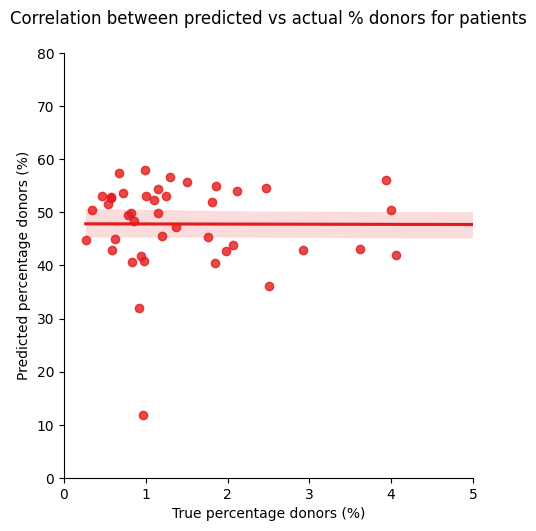

-0.08400833499937102 0.5618938363129893


<Figure size 640x480 with 0 Axes>

In [65]:
true_donor_percent = "calculated"

col_names = ["patient_sample_id", "num_samples", "donor_percentage", "Metadata Donor Percent", "DaysPostTransplant", "Clinical_signs_of_rejection", "patient_id"]
patient_labels_df = pd.read_csv(arguments["patientTransplantStatusFile"], sep = "\t", names= col_names, skiprows=1)
donor_percentage_predictions = list(allPlotsData["predicted_donor_percentage"].values())
if (true_donor_percent == "calculated"):
    true_donor_percentage = patient_labels_df[patient_labels_df['patient_sample_id'].isin( allPlotsData["predicted_donor_percentage"].keys())]["donor_percentage"]
else:
    true_donor_percentage = patient_labels_df[patient_labels_df['patient_sample_id'].isin( allPlotsData["predicted_donor_percentage"].keys())]["Metadata Donor Percent"]

donor_percentages = pd.DataFrame({
'Predicted Donor Percentage': donor_percentage_predictions,
'True Donor Percentage': true_donor_percentage
})

sns.lmplot(data=donor_percentages, x="True Donor Percentage", y="Predicted Donor Percentage")

# plt.scatter(true_donor_percentage, donor_percentage_predictions)
plt.title(f'Correlation between predicted vs actual % donors for patients', y = 1.05)
plt.xlabel('True percentage donors (%)')
plt.ylabel('Predicted percentage donors (%)')

#Set x lims
plt.xlim(0, 5)
plt.ylim(0, 80)

# if(arguments["storePlots"]):
#     plotPath = os.path.join(plotsDirectoryPath, "percentageDonorsCorrelationPlot")
#     plt.savefig(plotPath, bbox_inches='tight')
plt.show()
plt.clf()

correlation_coefficient, p_value = pearsonr(donor_percentage_predictions, true_donor_percentage)
print(correlation_coefficient, p_value)

**Make the plot of % predicted donors vs days post transplant coloured by whether or not clinical signs of rejection are observed**

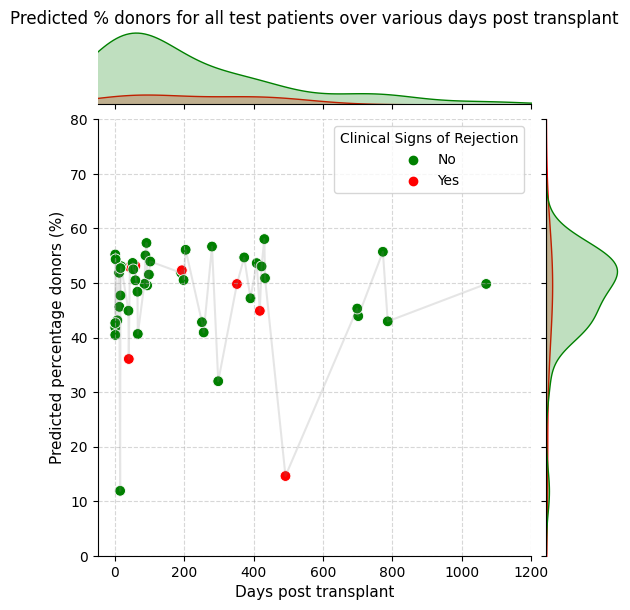

In [63]:
col_names = ["patient_sample_id", "num_samples", "donor_percentage", "Metadata Donor Percent", "DaysPostTransplant", "Clinical_signs_of_rejection", "patient_id"]
patient_labels_df = pd.read_csv(arguments["patientTransplantStatusFile"], sep = "\t", names= col_names, skiprows=1)

#Cope only some rows from the transplant status file to a new df - the rows for which the model predictions were obtained
predicted_percent_donors = allPlotsData["predicted_donor_percentage"]
condition = patient_labels_df['patient_sample_id'].isin(predicted_percent_donors.keys())
to_plot_df = patient_labels_df[condition].copy()
to_plot_df.reset_index(drop=True, inplace=True)

#To the copied df, add the percentage donor values from the model predictions
predicted_percent_donors_list = []
for index, row in to_plot_df.iterrows():
    predicted_percent_donors_list.append(predicted_percent_donors[row["patient_sample_id"]])

to_plot_df["predicted_percent_donors"] = predicted_percent_donors_list

colors = {"Yes": "red", "No": "green"}
# Create the scatter plots with different color palettes
scatter = sns.jointplot(data=to_plot_df, x="DaysPostTransplant", y="predicted_percent_donors", hue="Clinical_signs_of_rejection",palette=colors, s=60, xlim=(-50, 1200), ylim=(0, 80))
# scatter.legend_.set_title("Clinical Signs of Rejection")

sns.lineplot(data=to_plot_df, x="DaysPostTransplant", y='predicted_percent_donors', color="gray", alpha=0.2)
# plt.legend(title="Clinical Signs of Rejection")

# plt.ylim(0, 80)
plt.title(f"Predicted % donors for all test patients over various days post transplant", y = 1.2, fontsize=12)
plt.xlabel('Days post transplant', fontsize=11)
plt.ylabel('Predicted percentage donors (%)', fontsize=11)

plt.legend(title="Clinical Signs of Rejection")
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

['L80' 'L79' 'L68' 'L77' 'L81' 'L9b' 'L82' 'L74' 'L85' 'L33' 'L5' 'L34'
 'L16' 'L59' 'L35' 'L2' 'L69' 'L49' 'L30' 'L36' 'L21' 'L50' 'L4' 'L11'
 'L57' 'L28' 'L1' 'L58' 'L31' 'L25']


/tmp/ipykernel_1929801/2048676777.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_plot_df = to_plot_df[condition]


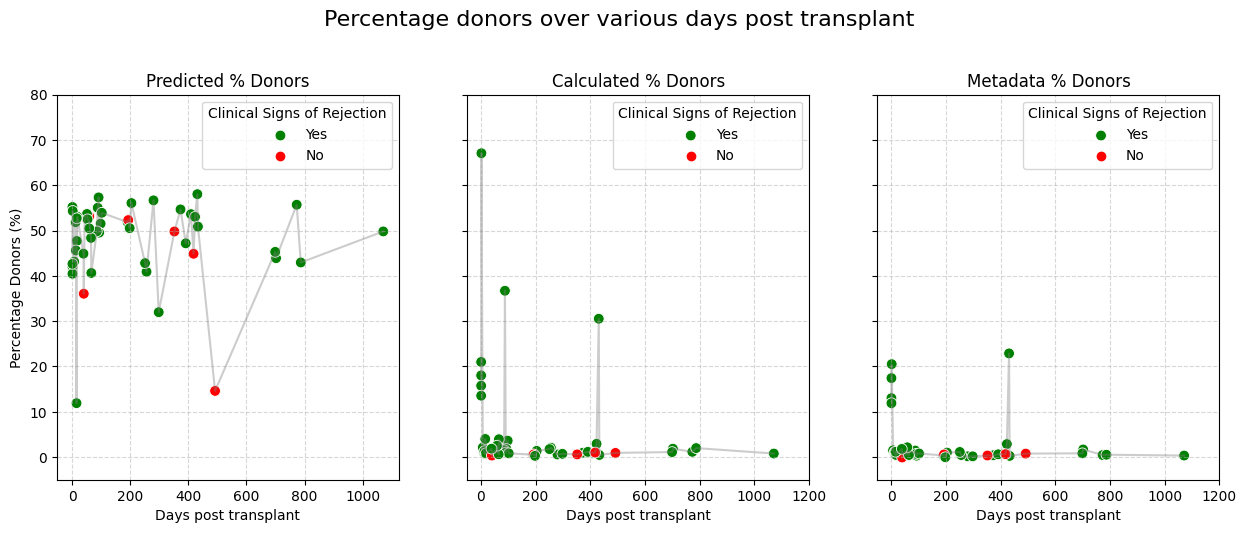

In [27]:
col_names = ["patient_sample_id", "num_samples", "donor_percentage", "Metadata Donor Percent", "DaysPostTransplant", "Clinical_signs_of_rejection", "patient_id"]
patient_labels_df = pd.read_csv(arguments["patientTransplantStatusFile"], sep = "\t", names= col_names, skiprows=1)

print(patient_labels_df["patient_id"].unique())

#Get only the rows from the metadata for which percent donors predictions are available.
predicted_percent_donors = allPlotsData["predicted_donor_percentage"]
condition = patient_labels_df['patient_sample_id'].isin(predicted_percent_donors.keys())
to_plot_df = patient_labels_df[condition].copy()
to_plot_df.reset_index(drop=True, inplace=True)

#There's one calculated donor percentage which is about 200. Its throwing off all the graphs. Remove that value 
condition = patient_labels_df['donor_percentage'] < 75
to_plot_df = to_plot_df[condition]

#To the copied df, add the percentage donor values from the model predictions
predicted_percent_donors_list = []
for index, row in to_plot_df.iterrows():
    predicted_percent_donors_list.append(predicted_percent_donors[row["patient_sample_id"]])

to_plot_df["predicted_percent_donors"] = predicted_percent_donors_list

#Start plotting all the 3 graphs 
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)
colors = {"Yes": "red", "No": "green"}
hue_order = ["Yes", "No"]
legend_colors = {"Yes": "red", "No": "green"}

sns.scatterplot(data=to_plot_df, x="DaysPostTransplant", y="predicted_percent_donors", hue="Clinical_signs_of_rejection",palette=colors, s=60, ax = axes[0], hue_order = hue_order)
sns.lineplot(data=to_plot_df, x="DaysPostTransplant", y='predicted_percent_donors', color="gray", alpha=0.4, ax = axes[0])
axes[0].set_title("Predicted % Donors")
axes[0].set_xlabel("Days post transplant")
axes[0].set_ylabel("Percentage Donors (%)")
axes[0].legend(title="Clinical Signs of Rejection", labels=hue_order)
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[1].set(xlim=(-50, 1200), ylim=(-5, 80)) 
# axes[0].set_xlim(-50, 1200)
# axes[0].set_ylim=(0, 80)

sns.scatterplot(data=to_plot_df, x="DaysPostTransplant", y="donor_percentage", hue="Clinical_signs_of_rejection",palette=colors, s=60, ax = axes[1], hue_order = hue_order)
sns.lineplot(data=to_plot_df, x="DaysPostTransplant", y='donor_percentage', color="gray", alpha=0.4, ax = axes[1])
axes[1].set_title("Calculated % Donors")
axes[1].set_xlabel("Days post transplant")
axes[1].set_ylabel("Percentage Donors (%)")
axes[1].legend(title="Clinical Signs of Rejection", labels=hue_order)
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].set_xlim(-50, 1200)
axes[1].set_ylim=(-10, 80)

sns.scatterplot(data=to_plot_df, x="DaysPostTransplant", y="Metadata Donor Percent", hue="Clinical_signs_of_rejection",palette=colors, s=60, ax = axes[2], hue_order = hue_order)
sns.lineplot(data=to_plot_df, x="DaysPostTransplant", y='Metadata Donor Percent', color="gray", alpha=0.4, ax = axes[2])
axes[2].set_title("Metadata % Donors")
axes[2].set_xlabel("Days post transplant")
axes[2].set_ylabel("Percentage Donors (%)")
axes[2].legend(title="Clinical Signs of Rejection", labels=hue_order)
axes[2].grid(True, linestyle='--', alpha=0.5)
axes[2].set_xlim(-50, 1200)
axes[2].set_ylim=(-10, 80)

fig.suptitle("Percentage donors over various days post transplant", y=1.05, fontsize=16)

plt.show()

**Make the same plot of % predicted donors vs days post transplant as above, but chat GPT improved**

**If patient plots data is already stored, make confusion matrix and ROC curves from them**
(NOTE - the plotsData for many test patients becomes really huge, you need a lot of memory and running time is also high)

PART 1 - Just load the data from the 1st file

In [6]:
plotsDir = "/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/trainingValidationPlotsAndMetrics/final_report_patient_level_plots/15_11_23_21_08_all_test_patients"
data_pickle_file_path = os.path.join(plotsDir, "testPatientsData.pkl")

with open(data_pickle_file_path, "rb") as f:
    allPlotsData = pickle.load(f)

print(f"Finished loading first set of data")

Finished loading first set of data


Get the output probabilities and class predictions for the 1st set of data, plot AUC/ROC curve and the confusion matrix all in separate cells

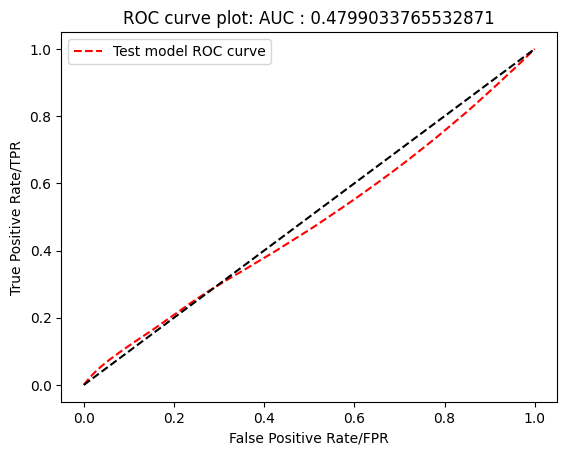

<Figure size 640x480 with 0 Axes>

In [8]:
output_probabilities, class_predictions = getClassPredictionsAndProbsFromOutput(allPlotsData)

In [ ]:
storeAucAndRocCurve(output_probabilities, allPlotsData, plotsDir)

Text(0.5, 0.2, 'Confusion matrix for test patient fragments')

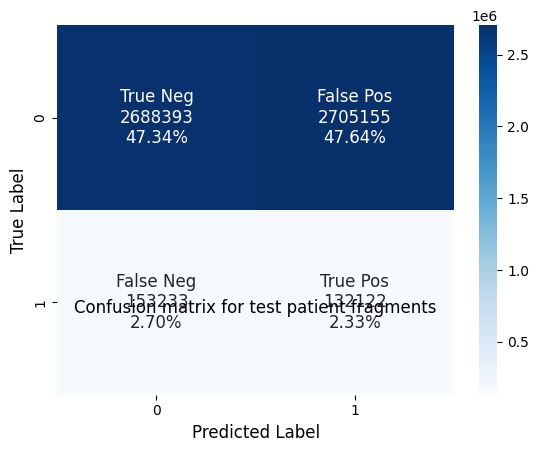

In [11]:
fragment_true_labels = allPlotsData["labels"]
fragment_cf_matrix = confusion_matrix(fragment_true_labels, class_predictions)
fragment_cf_matrix_labels = getConfusionMatrixLabels(fragment_cf_matrix)

Text(0.5, 1.05, 'Confusion matrix for test patient fragments')

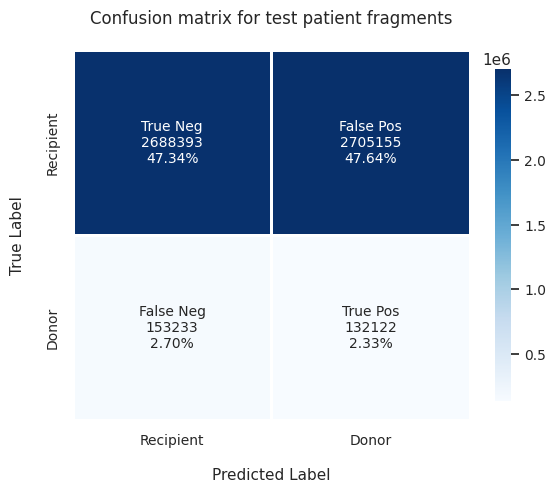

In [58]:
import matplotlib.patches as patches

sns.set_theme(style="whitegrid")

s = sns.heatmap(fragment_cf_matrix, annot=fragment_cf_matrix_labels, fmt = '', cmap="Blues", annot_kws={"fontsize":10}, linewidths=1, linecolor='white', cbar_kws={"shrink": 0.9})
s.set_xlabel("Predicted Label", fontsize=11, labelpad=15)
s.set_ylabel("True Label", fontsize=11, labelpad = 15)
s.set_xticklabels(["Recipient", "Donor"])
s.set_yticklabels(["Recipient", "Donor"])

cbar = s.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
s.tick_params(axis='both', which='both', labelsize=10)

# # Add a border around the entire heatmap
# rect = patches.Rectangle((0,0),  # (x,y)
#                          s.get_xlim()[1],  # width
#                          s.get_ylim()[1],  # height
#                          linewidth=1, edgecolor='black', facecolor='none')
# s.add_patch(rect)

plt.title("Confusion matrix for test patient fragments", y = 1.05)

PART 2 - Load the data from the 2nd file

In [ ]:
def storeDataAndMakePlots(plotsDirectoryPath, plotsData, class_predictions, output_probabilities, modelInputType):
    plt.style.use('seaborn')
    arguments["modelInputType"] = modelInputType

    output_probabilities, class_predictions = getClassPredictionsAndProbsFromOutput(plotsData)
    
    storeAucAndRocCurve(output_probabilities, plotsData, plotsDirectoryPath)

    #Plot confusion matrix heat map for training and validation (only for last epoch)
    storeConfusionMatrixHeatMap(plotsData, class_predictions, plotsDirectoryPath)

    #Plot the correlation between predicted percentage donors and actual percentage donors for each sample 
    storePredictedDonorsCorrelationPlot(plotsData, plotsDirectoryPath)

    # Plot the predicted percentage dd-cfDNA over days of transplant for a patient. 
    
    storePercentDdCfDnaTransplantDaysPlot(plotsData)

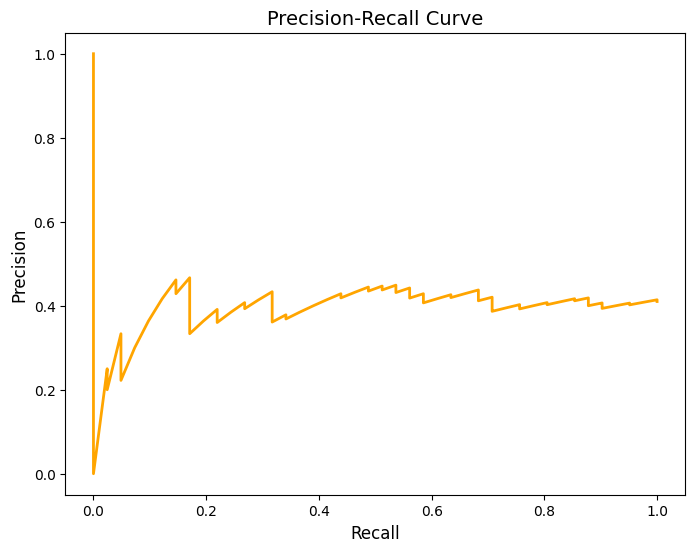

<Figure size 640x480 with 0 Axes>

In [5]:
positive_probs = np.random.rand(100)

# Generating corresponding true labels (0 or 1)
true_labels = np.random.randint(2, size=100)

def plot_precision_recall_curve(positive_probs, true_labels):
    precision, recall, thresholds = precision_recall_curve(true_labels, positive_probs)

    # Plot the precision-recall curve with style enhancements
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Precision-Recall Curve', color='orange', linewidth=2)  # Brighter color, thicker line

    # Set labels and title
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curve', fontsize=14)

    plt.show()

    # Clear the current figure
    plt.clf()

plot_precision_recall_curve(positive_probs, true_labels)